In [13]:
# import packages
import librosa
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
%matplotlib inline

In [14]:
# set window size and hop size
len_window = 1024
len_hop = 256

In [15]:
## to get music from youtube:
    # convert youtube video to mp3: https://ytmp3.cc/
    # then convert mp3 to wav: https://convertio.co/kr/mp3-wav/


# load music
sound, sample_rate = librosa.load('MIR-1K/Wavfile/abjones_1_01.wav', mono=False)
#sound, sample_rate = librosa.load('input/redvelvet-redflavor.wav', mono=False)
#sound, sample_rate = librosa.load('input/twice-tt.wav', mono=False)

# convert stereo music to monaural file
mono = librosa.to_mono(sound)
# stft conversion
spectrogram_mono = librosa.stft(mono, n_fft=len_window, hop_length=len_hop).astype(np.float32)

/Users/rachelmoon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  


In [16]:
# https://github.com/dganguli/robust-pca/blob/master/r_pca.py
class R_pca:
    def __init__(self, D, mu=None, lmbda=None):
        self.D = D
        self.S = np.zeros(self.D.shape)
        self.Y = np.zeros(self.D.shape)

        if mu:
            self.mu = mu
        else:
            self.mu = np.prod(self.D.shape) / (4 * self.norm_p(self.D, 2))

        self.mu_inv = 1 / self.mu

        if lmbda:
            self.lmbda = lmbda
        else:
            self.lmbda = 1 / np.sqrt(np.max(self.D.shape))

    @staticmethod
    def norm_p(M, p):
        return np.sum(np.power(M, p))

    @staticmethod
    def shrink(M, tau):
        return np.sign(M) * np.maximum((np.abs(M) - tau), np.zeros(M.shape))

    def svd_threshold(self, M, tau):
        U, S, V = np.linalg.svd(M, full_matrices=False)
        return np.dot(U, np.dot(np.diag(self.shrink(S, tau)), V))

    def fit(self, tol=None, max_iter=1000, iter_print=100):
        iter = 0
        err = np.Inf
        Sk = self.S
        Yk = self.Y
        Lk = np.zeros(self.D.shape)

        if tol:
            _tol = tol
        else:
            _tol = 1E-7 * self.norm_p(np.abs(self.D), 2)

        while (err > _tol) and iter < max_iter:
            Lk = self.svd_threshold(
                self.D - Sk + self.mu_inv * Yk, self.mu_inv)
            Sk = self.shrink(
                self.D - Lk + (self.mu_inv * Yk), self.mu_inv * self.lmbda)
            Yk = Yk + self.mu * (self.D - Lk - Sk)
            err = self.norm_p(np.abs(self.D - Lk - Sk), 2)
            iter += 1
            if (iter % iter_print) == 0 or iter == 1 or iter > max_iter or err <= _tol:
                print('iteration: {0}, error: {1}'.format(iter, err))

        self.L = Lk
        self.S = Sk
        return Lk, Sk

    def plot_fit(self, size=None, tol=0.1, axis_on=True):

        n, d = self.D.shape

        if size:
            nrows, ncols = size
        else:
            sq = np.ceil(np.sqrt(n))
            nrows = int(sq)
            ncols = int(sq)

        ymin = np.nanmin(self.D)
        ymax = np.nanmax(self.D)
        print('ymin: {0}, ymax: {1}'.format(ymin, ymax))

        numplots = np.min([n, nrows * ncols])
        plt.figure()

        for n in range(numplots):
            plt.subplot(nrows, ncols, n + 1)
            plt.ylim((ymin - tol, ymax + tol))
            plt.plot(self.L[n, :] + self.S[n, :], 'r')
            plt.plot(self.L[n, :], 'b')
            if not axis_on:
                plt.axis('off')

In [17]:
RPCA = R_pca(spectrogram_mono)
L, S = RPCA.fit(max_iter=10000, iter_print=100)

iteration: 1, error: 1737.047517303276
iteration: 95, error: 0.06135969625774568


In [18]:
# binary time-frequency masking
# set gain = 1 as in the paper
M_b = 1 * (np.abs(S) > 2 * np.abs(L))

X_singing = np.multiply(M_b, spectrogram_mono)
X_music = np.multiply((1 - M_b), spectrogram_mono)

In [51]:
# plot too small so change this!

#RPCA.plot_fit()
#plt.show()

In [19]:
# L is the background music separated out from the original song
# S is the singing voice separated out from the original song
# If you don't use (binary) time frequency masking, then just use S
output = librosa.istft(S)

# output using binary time frequency masking
output_better = librosa.istft(X_singing)

In [20]:
librosa.output.write_wav(path = 'output/abjones_1_01_voice.wav', y = output, sr = sample_rate, norm = False)

In [21]:
# with binary frequency mask
librosa.output.write_wav(path = 'output/abjones_1_01_voice_mask.wav', y = output_better, sr = sample_rate, norm = False)

In [12]:
output_L=librosa.istft(L)
librosa.output.write_wav(path = 'output/twice-tt-mr.wav', y = output_L, sr = sample_rate, norm = False)

output_L=librosa.istft(X_music)
librosa.output.write_wav(path = 'output/twice-tt-mr_better.wav', y = output_L, sr = sample_rate, norm = False)

In [28]:
# from https://stackoverflow.com/questions/44787437/how-to-convert-a-wav-file-to-a-spectrogram-in-python3
import os
import wave

import pylab
def graph_spectrogram(wav_file):
    sound_info, frame_rate = get_wav_info(wav_file)
    pylab.figure(num=None, figsize=(19, 12))
    pylab.subplot(111)
    pylab.title('spectrogram of %r' % wav_file)
    pylab.specgram(sound_info, Fs=frame_rate)
    pylab.savefig('spectrogram.png')
def get_wav_info(wav_file):
    wav = wave.open(wav_file, 'r')
    frames = wav.readframes(-1)
    sound_info = pylab.frombuffer(frames, 'int16')
    frame_rate = wav.getframerate()
    wav.close()
    return sound_info, frame_rate

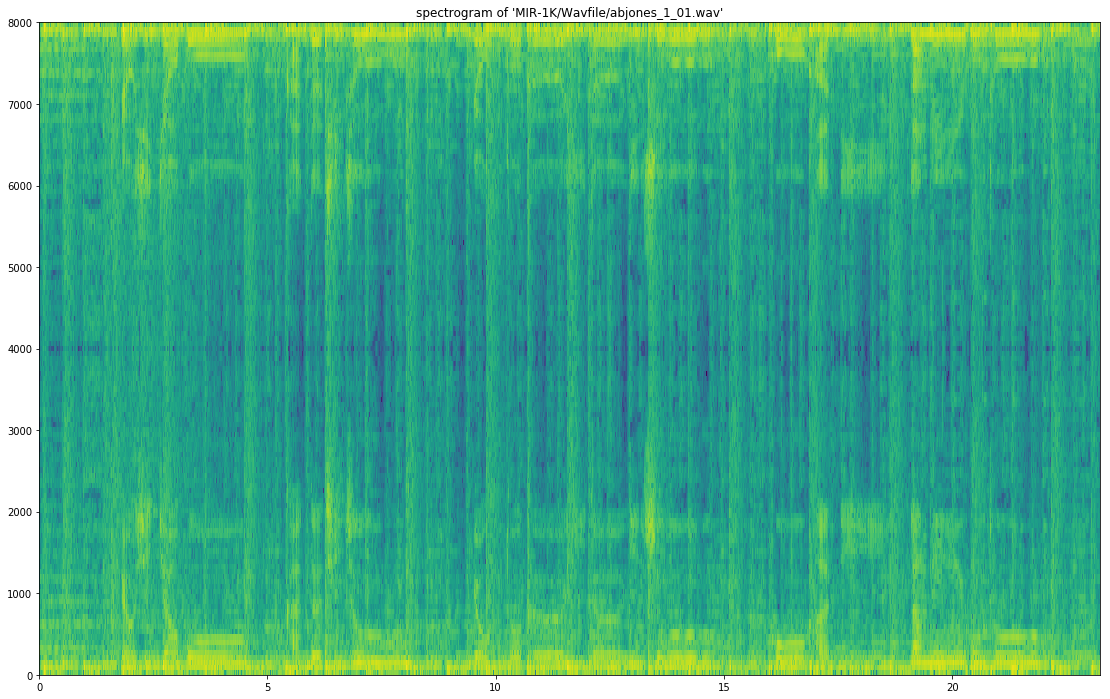

In [29]:
graph_spectrogram('MIR-1K/Wavfile/abjones_1_01.wav')

In [30]:
graph_spectrogram('output/abjones_1_01_voice.wav')

Error: unknown format: 3